In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (make_scorer,
                             roc_auc_score,
                             roc_curve,
                             f1_score,
                             recall_score,
                             precision_score,
                             precision_recall_curve,
                             classification_report,
                             plot_confusion_matrix,
                             plot_roc_curve)
import joblib
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

seed = 36

In [2]:
train = pd.read_csv('../data/notebook_produced_3/train.csv')

train.head()

,pdays,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,day_of_week_wed,poutcome_failure,poutcome_success,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,-0.1,0.93200,-42.0,4.191,5195.8,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1.1,0.93994,-36.4,4.857,5191.0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1.4,0.93918,-42.7,4.962,5228.1,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1.4,0.93918,-42.7,4.958,5228.1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,-0.1,0.93200,-42.0,4.076,5195.8,0


# split data into train and val

In [3]:
X = train.drop(columns='y')
y = train.y

(X_train, X_val,
 y_train, y_val) = train_test_split(
                                X, y,
                                test_size=0.33,
                                stratify=y,
                                random_state=seed
                                )

## train with gridsearch

#### RandomForest

In [4]:
def myGridSearchCv(model, params, X, y):
    clf = GridSearchCV(
                estimator=model,
                param_grid=params,
                scoring='roc_auc',
                cv=5,
                n_jobs=-1,
                return_train_score=True)
    clf.fit(X, y)
    return clf

rand_forest = RandomForestClassifier(random_state=seed)
grid_params = {
#     'n_estimators': [50, 100, 150, 200, 250],
#     'criterion': ['gini'],
#     'max_depth': [10, 20, 30, 40, 50]

#     'n_estimators': [130],
#     'criterion': ['gini'],
#     'max_depth': [22]

    'n_estimators': [50],
    'criterion': ['gini'],
    'max_depth': [20]
}

grid_rand_forest = myGridSearchCv(
                        rand_forest,
                        grid_params,
                        X_train, y_train)

test_scores = grid_rand_forest.cv_results_['mean_test_score']
train_scores = grid_rand_forest.cv_results_['mean_train_score']
params = grid_rand_forest.cv_results_['params']
params = [f"{d['criterion']}, depth:{d['max_depth']}, trees: {d['n_estimators']}" for d in params]

s = pd.DataFrame(np.vstack((test_scores, train_scores, params)).T, columns=['test_score', 'train_score', 'params'])
s.test_score = s.test_score.astype(float)
s.train_score = s.train_score.astype(float)
s['diff'] = s.train_score - s.test_score
s.head()

,test_score,train_score,params,diff
0,0.945334,0.984511,"gini, depth:20, trees: 50",0.039177


In [5]:
rand_forest = RandomForestClassifier(n_estimators=50,
                                     criterion='gini',
                                     max_depth=20,
                                     random_state=seed)
rand_forest.fit(X_train, y_train)

train_score = roc_auc_score(y_train, rand_forest.predict_proba(X_train)[:, 1])
val_score = roc_auc_score(y_val, rand_forest.predict_proba(X_val)[:,1])

print(' Train AUC:', train_score)
print('   Val AUC:', val_score)
print('Difference:', train_score - val_score)

 Train AUC: 0.9832300826522217
   Val AUC: 0.9487504315294112
Difference: 0.034479651122810484


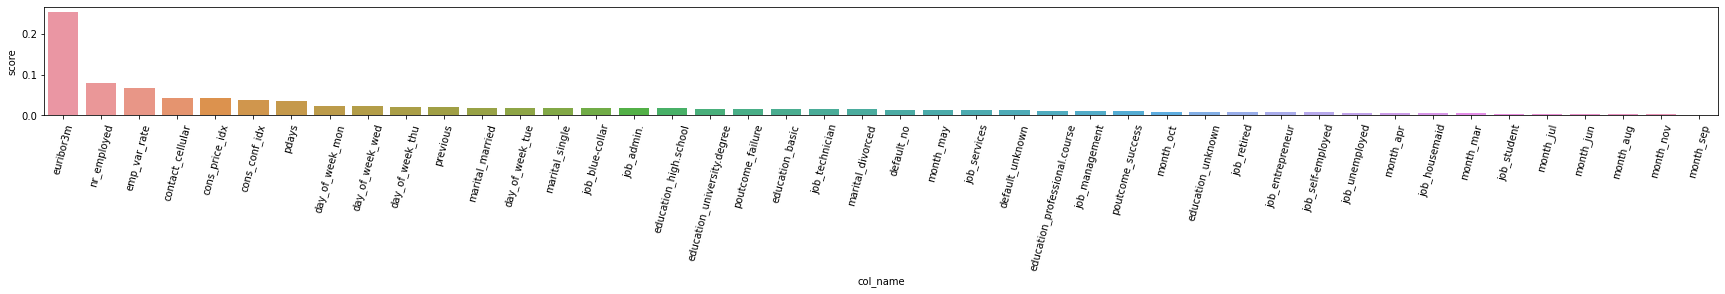

In [6]:
f_imp = pd.DataFrame([X.columns, rand_forest.feature_importances_]).T
f_imp.columns = ['col_name', 'score']
f_imp = f_imp.sort_values('score', ascending=False)
f_imp = f_imp.reset_index(drop=True)

f, ax = plt.subplots(figsize=(30, 2))
sns.barplot(data=f_imp, x='col_name', y='score', ax=ax)
ax.tick_params(axis='x', labelrotation=75);

### Whittle down the features to the ones that actually give good signal

##### some lose in model performance should be expected on the training and validation sets, but hopefully this will make the predictions more predictable on the holdout set and realworld new data

In [8]:
train_score = roc_auc_score(y_train, rand_forest.predict_proba(X_train)[:, 1])
val_score = roc_auc_score(y_val, rand_forest.predict_proba(X_val)[:,1])

print(' Train AUC:', train_score)
print('   Val AUC:', val_score)
print('Difference:', train_score - val_score)

 Train AUC: 0.9832300826522217
   Val AUC: 0.9487504315294112
Difference: 0.034479651122810484


In [105]:
ordered_cals = f_imp.col_name.to_list()
l = []
for i in range(1, len(ordered_cals)):
    current_cols = ordered_cals[:-i]


    grid_params = {
#         'n_estimators': [50],
#         'criterion': ['gini'],
#         'max_depth': [20]

        'n_estimators': [20, 30, 40, 50, 60, 70, 80],
        'criterion': ['gini'],
        'max_depth': [10, 15, 20, 25, 30]
    }
    rand_forest = RandomForestClassifier(random_state=seed)
    grid_rand_forest = myGridSearchCv(
                            rand_forest,
                            grid_params,
                            X_train.loc[:, current_cols], y_train)

    test_scores = grid_rand_forest.cv_results_['mean_test_score'].tolist()
    train_scores = grid_rand_forest.cv_results_['mean_train_score'].tolist()
    params = grid_rand_forest.cv_results_['params']
    params = [f"{d['criterion']}, depth:{d['max_depth']}, trees: {d['n_estimators']}" for d in params]
    col_count = [len(current_cols) for i in range(len(params))]
    l += pd.DataFrame([col_count, train_scores, test_scores, params]).T.to_numpy().tolist()
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


In [138]:
lots_of_scores = pd.DataFrame(l, columns=['col_count', 'train_scores', 'test_scores', 'params'])
lots_of_scores['diff'] = lots_of_scores.train_scores - lots_of_scores.test_scores
lots_of_scores

,col_count,train_scores,test_scores,params,diff
0,43,0.888036,0.873938,"gini, depth:10, trees: 20",0.014098
1,43,0.889234,0.874994,"gini, depth:10, trees: 30",0.014240
2,43,0.888202,0.874090,"gini, depth:10, trees: 40",0.014111
3,43,0.888663,0.874554,"gini, depth:10, trees: 50",0.014109
4,43,0.888702,0.874574,"gini, depth:10, trees: 60",0.014128
...,...,...,...,...,...
1500,1,0.906947,0.897021,"gini, depth:30, trees: 40",0.009926
1501,1,0.906977,0.897046,"gini, depth:30, trees: 50",0.009931
1502,1,0.906979,0.897026,"gini, depth:30, trees: 60",0.009953
1503,1,0.906991,0.897056,"gini, depth:30, trees: 70",0.009935


In [130]:
# f, (a1, a2, a3) = plt.subplots(nrows=3, figsize=(30, 10))
# sns.scatterplot(data=lots_of_scores, x='params', y='train_scores', hue='col_count', ax=a1)
# sns.scatterplot(data=lots_of_scores, x='params', y='test_scores', hue='col_count', ax=a2)

# sns.scatterplot(data=lots_of_scores, x='params', y='diff', hue='col_count', ax=a3)
# a3.tick_params(axis='x', labelrotation=90);

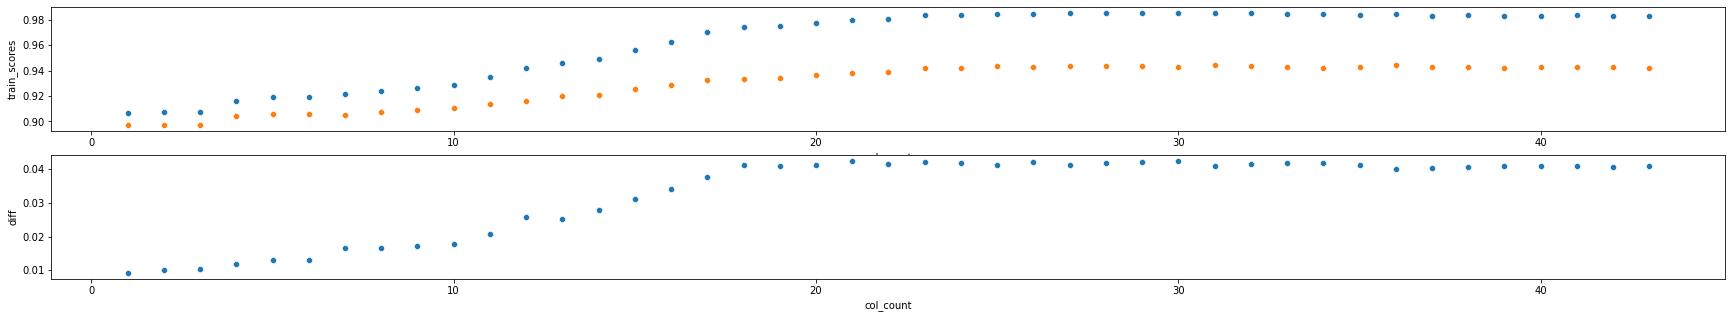

In [139]:
a = lots_of_scores.loc[lots_of_scores.params=='gini, depth:20, trees: 20', :]

f, (a1, a2) = plt.subplots(nrows=2, figsize=(30, 5))
sns.scatterplot(data=a, x='col_count', y='train_scores', ax=a1)
sns.scatterplot(data=a, x='col_count', y='test_scores', ax=a1)
sns.scatterplot(data=a, x='col_count', y='diff', ax=a2);

In [150]:
# 23
best_cols = ordered_cals[:-21]

X_train = X_train.loc[:, best_cols]
X_val = X_val.loc[:, best_cols]

rand_forest = RandomForestClassifier(n_estimators=20,
                                     criterion='gini',
                                     max_depth=20,
                                     random_state=seed)
rand_forest.fit(X_train, y_train)

train_score = roc_auc_score(y_train, rand_forest.predict_proba(X_train)[:, 1])
val_score = roc_auc_score(y_val, rand_forest.predict_proba(X_val)[:,1])

print(' Train AUC:', train_score)
print('   Val AUC:', val_score)
print('Difference:', train_score - val_score)

 Train AUC: 0.9830215611902965
   Val AUC: 0.9447661291907556
Difference: 0.038255431999540845


In [151]:
print('Validation Classification Report\n')
print(classification_report(y_val, rand_forest.predict(X_val)))

Validation Classification Report

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      8443
           1       0.88      0.87      0.87      8443

    accuracy                           0.87     16886
   macro avg       0.87      0.87      0.87     16886
weighted avg       0.87      0.87      0.87     16886



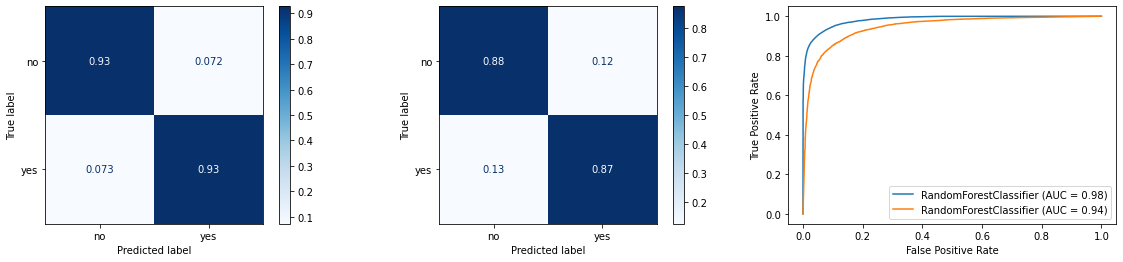

In [195]:
f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,4))
plot_confusion_matrix(rand_forest,
                      X_train, y_train,
                      display_labels=['no', 'yes'],
                      cmap=plt.cm.Blues,
                      normalize='true',
                      ax=ax1
                     )
plot_confusion_matrix(rand_forest,
                      X_val, y_val,
                      display_labels=['no', 'yes'],
                      cmap=plt.cm.Blues,
                      normalize='true',
                      ax=ax2
                     )
plot_roc_curve(rand_forest,
               X_train, y_train, ax=ax3)
plot_roc_curve(rand_forest,
               X_val, y_val, ax=ax3);

In [197]:
# joblib.dump(rand_forest, '../saved_models/rand_forest_trees_20_depth_20.joblib')

['../saved_models/rand_forest_trees_20_depth_20.joblib']

In [215]:
def tp_tn_fn_fp(true_value, predicted_value):
    tp, tn, fn, fp = 0, 0, 0, 0
    for v, p in zip(true_value, predicted_value):
        if v == p:
            if v+p == 2: tp += 1
            else: tn += 1
        elif v == 1: fn += 1
        else: fp += 1
    return tp, tn, fn, fp

def lift_score(true_value, predicted_value):
    tp, tn, fn, fp = tp_tn_fn_fp(true_value, predicted_value)
    return ( tp/(tp+fp) ) / ( (tp+fn) / (tp+tn+fp+fn) )

In [200]:
X_train['y'] = y_train
X_val['y'] = y_val

(34282, 24)

In [207]:
df_train = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
df_train.shape

(51168, 24)

### subset the holdout set...again

In [213]:
test = pd.read_csv('../data/notebook_produced_3/test.csv')
test = test.loc[:, df_train.columns]
test.shape

(12356, 24)

In [209]:
# df_train.to_csv('../data/notebook_produced_4/train.csv', index=False)
# test.to_csv('../data/notebook_produced_4/test.csv', index=False)

In [ ]:
fpr_train, tpr_train, _ = roc_curve(y_train, grid_rand_forest.predict_proba(X_train)[:,1])
fpr_val, tpr_val, _ = roc_curve(y_val, grid_rand_forest.predict_proba(X_val)[:,1])

f, ax = plt.subplots(figsize=(8, 7))
sns.scatterplot(x=fpr_train, y=tpr_train, ax=ax)
sns.scatterplot(x=fpr_val, y=tpr_val, ax=ax)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate');

In [ ]:
rand_forest = RandomForestClassifier(n_estimators=130, criterion='gini', max_depth=22, random_state=seed)
rand_forest.fit(X_train, y_train)

In [ ]:
print('Train AUC:', roc_auc_score(y_train, rand_forest.predict_proba(X_train)[:, 1]))
print('  Val AUC:', roc_auc_score(y_val, rand_forest.predict_proba(X_val)[:,1]))

In [ ]:
f_imp = pd.DataFrame([X.columns, rand_forest.feature_importances_]).T
f_imp.columns = ['col_name', 'score']
f_imp = f_imp.sort_values('score', ascending=False)
f_imp = f_imp.reset_index(drop=True)
f_imp.head()

In [ ]:
f_imp

In [ ]:
f, ax = plt.subplots(figsize=(30, 3))
sns.barplot(data=f_imp, x='col_name', y='score', ax=ax)
ax.tick_params(axis='x', labelrotation=75);

In [ ]:
top_cols = list(f_imp.iloc[:10, 0].values)
top_cols += ['poutcome_failure', 'poutcome_success']
top_cols

In [ ]:
X_train_subset = X_train.loc[:, top_cols]
X_val_subset = X_val.loc[:, top_cols]

In [ ]:
X_val_subset.head()

In [ ]:
rand_forest = RandomForestClassifier(n_estimators=130, criterion='gini', max_depth=22, random_state=seed)
rand_forest.fit(X_train_subset, y_train)

In [ ]:
print('Train AUC:', roc_auc_score(y_train, rand_forest.predict_proba(X_train_subset)[:, 1]))
print('  Val AUC:', roc_auc_score(y_val, rand_forest.predict_proba(X_val_subset)[:,1]))

In [ ]:
X_val.head()

In [ ]:
test = pd.read_csv('../data/notebook_produced_3/test.csv')
X_hold = test.drop(columns='y')
y_hold = test.y

# X_hold_subset = X_hold.loc[:, top_cols]
# X_hold = X_hold.loc[:, ['euribor3m']]
X_hold = X_hold.loc[:, ['poutcome_success', 'poutcome_failure']]
X_hold.shape

In [ ]:
print('  Val AUC:', roc_auc_score(y_hold, grid_rand_forest.predict_proba(X_hold)[:,1]))

In [ ]:
plot_confusion_matrix(grid_rand_forest,
                      X_hold, y_hold,
                      display_labels=['no', 'yes'],
                      cmap=plt.cm.Blues,
                      normalize='true'
                     );

In [ ]:
# print('  Val AUC:', roc_auc_score(y_hold, rand_forest.predict_proba(X_hold_subset)[:,1]))

print('  Val AUC:', roc_auc_score(y_hold, rand_forest.predict_proba(X_hold)[:,1]))

In [ ]:
# f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
# plot_confusion_matrix(rand_forest,
#                       X_val_subset, y_val,
#                       display_labels=['no', 'yes'],
#                       cmap=plt.cm.Blues,
#                       normalize='true',
#                       ax=ax1
#                      )
# plot_confusion_matrix(rand_forest,
#                       X_hold_subset, y_hold,
#                       display_labels=['no', 'yes'],
#                       cmap=plt.cm.Blues,
#                       normalize='true',
#                       ax=ax2
#                      );

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
plot_confusion_matrix(rand_forest,
                      X_val, y_val,
                      display_labels=['no', 'yes'],
                      cmap=plt.cm.Blues,
                      normalize='true',
                      ax=ax1
                     )
plot_confusion_matrix(rand_forest,
                      X_hold, y_hold,
                      display_labels=['no', 'yes'],
                      cmap=plt.cm.Blues,
                      normalize='true',
                      ax=ax2
                     );


#### AdaBoost

In [ ]:
def myGridSearchCv(model, params, X, y):
    clf = GridSearchCV(
                estimator=model,
                param_grid=params,
                scoring='roc_auc',
                cv=5,
                n_jobs=-1,
                return_train_score=True)
    clf.fit(X, y)
    return clf

adaBoost = AdaBoostClassifier(random_state=seed)

grid_params = {
#         'n_estimators': [200, 250, 275, 300],
#         'learning_rate': [1.6, 1.7, 1.8]
        'n_estimators': [300],
        'learning_rate': [1.8]
}

grid_adaBoost = myGridSearchCv(
                        adaBoost,
                        grid_params,
                        X_train, y_train)

test_scores = grid_adaBoost.cv_results_['mean_test_score']
train_scores = grid_adaBoost.cv_results_['mean_train_score']
params = grid_adaBoost.cv_results_['params']
params = [f"l_rate:{d['learning_rate']}, trees:{d['n_estimators']}" for d in params]

s = pd.DataFrame(np.vstack((test_scores, train_scores, params)).T, columns=['test_score', 'train_score', 'params'])
s.test_score = s.test_score.astype(float)
s.train_score = s.train_score.astype(float)
s['diff'] = s.train_score - s.test_score
s.head()

In [ ]:
print('Train AUC:', roc_auc_score(y_train, grid_adaBoost.predict_proba(X_train)[:, 1]))
print('  Val AUC:', roc_auc_score(y_val, grid_adaBoost.predict_proba(X_val)[:,1]))

In [ ]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
plot_confusion_matrix(grid_adaBoost,
                      X_train, y_train,
                      display_labels=['no', 'yes'],
                      cmap=plt.cm.Blues,
                      normalize='true',
                      ax=ax1
                     )
plot_confusion_matrix(grid_adaBoost,
                      X_val, y_val,
                      display_labels=['no', 'yes'],
                      cmap=plt.cm.Blues,
                      normalize='true',
                      ax=ax2
                     );

In [ ]:
fpr_train, tpr_train, _ = roc_curve(y_train, grid_adaBoost.predict_proba(X_train)[:,1])
fpr_val, tpr_val, _ = roc_curve(y_val, grid_adaBoost.predict_proba(X_val)[:,1])

f, ax = plt.subplots(figsize=(8, 7))
sns.scatterplot(x=fpr_train, y=tpr_train, ax=ax)
sns.scatterplot(x=fpr_val, y=tpr_val, ax=ax)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate');

In [ ]:
# f, (a1, a2) = plt.subplots(nrows=2, figsize=(30, 8))
# sns.scatterplot(data=s, x='params', y='test_score', ax=a1)
# sns.scatterplot(data=s, x='params', y='train_score', ax=a1)

# sns.scatterplot(data=s, x='params', y='diff', ax=a2)
# a2.tick_params(axis='x', labelrotation=45);

In [ ]:
# joblib.dump(model, '../saved_models/final_adaboost_poutcome_success.joblib')

In [ ]:
# joblib.dump(model, '../saved_models/final_adaboost_poutcome_other.joblib')

In [ ]:
test = pd.read_csv('../data/notebook_produced_3/test.csv')

success_df = test.loc[test.poutcome_success==1, :]
success_df = success_df.drop(columns=['poutcome_failure', 'poutcome_success', 'pdays'])

other_df = test.loc[test.poutcome_success==0, :]
other_df = other_df.drop(columns=['poutcome_success'])


X_other = other_df.drop(columns='y')
y_other = other_df.y

X_success = success_df.drop(columns='y')
y_success = success_df.y

X_other.shape, y_other.shape, X_success.shape, y_success.shape

In [ ]:
model_success = joblib.load('../saved_models/final_adaboost_poutcome_success.joblib')
model_other = joblib.load('../saved_models/final_adaboost_poutcome_other.joblib')

In [ ]:
f, ax = plt.subplots(figsize=(30, 4))
sns.barplot(x=X_success.columns, y=model_success.feature_importances_, ax=ax)
ax.tick_params(axis='x', labelrotation=45);

In [ ]:
f, ax = plt.subplots(figsize=(30, 4))
sns.barplot(x=X_other.columns, y=model_other.feature_importances_, ax=ax)
ax.tick_params(axis='x', labelrotation=45);

In [ ]:
print(roc_auc_score(y_other, model_other.predict(X_other)))

print(classification_report(y_other, model_other.predict(X_other)))

plot_confusion_matrix(model_other, X_other, y_other,
                      display_labels=['no', 'yes'],
                      cmap=plt.cm.Blues,
                      normalize='true'
                     );

In [ ]:
print(roc_auc_score(y_success, model_success.predict(X_success)))

print(classification_report(y_success, model_success.predict(X_success)))

plot_confusion_matrix(model_success, X_success, y_success,
                      display_labels=['no', 'yes'],
                      cmap=plt.cm.Blues,
                      normalize='true'
                     );

In [ ]:
def tp_tn_fn_fp(true_value, predicted_value):
    tp, tn, fn, fp = 0, 0, 0, 0
    for v, p in zip(true_value, predicted_value):
        if v == p:
            if v+p == 2: tp += 1
            else: tn += 1
        elif v == 1: fn += 1
        else: fp += 1
    return tp, tn, fn, fp

def lift_score(true_value, predicted_value):
    tp, tn, fn, fp = tp_tn_fn_fp(true_value, predicted_value)
    return ( tp/(tp+fp) ) / ( (tp+fn) / (tp+tn+fp+fn) )

In [ ]:
yy = pd.concat([y_other, y_success], ignore_index=False)
yy_predict = np.hstack((model_other.predict(X_other), model_success.predict(X_success)))
yy_proba = np.hstack((model_other.predict_proba(X_other)[:,1], model_success.predict_proba(X_success)[:,1]))

In [ ]:
lift_score(yy, yy_predict)

In [ ]:
res = pd.DataFrame(np.column_stack((yy, yy_proba, yy_predict)),
                   columns=['target', 'probability', 'prediction'])
res

In [ ]:
population = res.target.value_counts()
population_ratio = population.loc[1.0]/population.sum()

l = []
for i in np.arange(0, 1, .1):
    d = res.loc[res.probability >= i,:]
#     count = d.shape[0]
    sample = d.target.value_counts()
    sample_ratio = sample.loc[1.0]/sample.sum()
#     l.append([round(i, ndigits=1), sample_ratio/population_ratio, count])
    l.append([round(i, ndigits=1), sample_ratio/population_ratio, f'Yes: {sample.loc[1.0]}, No: {sample.loc[0.0]}'])
above_prob = pd.DataFrame(l, columns=['above_probability', 'lift', 'count'])

above_prob

In [ ]:
f, ax = plt.subplots(figsize=(20,4))
sns.barplot(data=above_prob, x='above_probability', y='lift', ax=ax)

for row in above_prob.itertuples():
    ax.text(row.Index, row.lift, row.count, color='black', ha="center")

ax.hlines(1, -1,10);